In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import random
import os
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score, auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import itertools
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch.nn import functional as F
from sklearn.calibration import calibration_curve
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statkit.decision import NetBenefitDisplay
from statistics import mean
from calibrated_metrics import average_precision, calibrated_precision
from sklearn.metrics import make_scorer
from EHR_functions import lr_evaluation, lr_L2_evaluation, random_forest_evaluation, random_forest_evaluation_2, lr_simulation, lr_L2_simulation, rf_simulation, check_auprc, set_seed, Neural_Network_Evaluation, NN_simulation
print("finish import")

finish import


In [2]:
data = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')

imputer = IterativeImputer(random_state=100, max_iter=10)
imputer_data = imputer.fit(data)

In [3]:
imputed_df = imputer.transform(data)
df = pd.DataFrame(imputed_df, columns=data.columns)

In [4]:
#df = df.drop(['subject_id', 'hadm_id', 'icustay_id'], axis=1)
df.columns

Index(['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI',
       'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [5]:
#categorical_columns = ['gender', 'mort_hosp', 'admission_type', 'ethnicity']
categorical_columns = ['Sex', 'HeartDiseaseorAttack', 'Diabetes', 'Stroke']
categorical_data = df[categorical_columns]
categorical_data = categorical_data.astype({"Sex":'int',"HeartDiseaseorAttack":'int',"Diabetes":'int',"Stroke":'int'}) 
numerical_data = df.drop(categorical_columns, axis=1)

In [6]:
stdsc = StandardScaler()
numerical_data_norm = stdsc.fit_transform(numerical_data)
numerical_df_norm = pd.DataFrame(numerical_data_norm, columns = numerical_data.columns)
df = pd.concat([categorical_data, numerical_df_norm], axis=1)

In [7]:
np.array(df.isna().sum())

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [8]:
y = df["HeartDiseaseorAttack"]
X = df.loc[:, df.columns != "HeartDiseaseorAttack"]
y.value_counts()

HeartDiseaseorAttack
0    229787
1     23893
Name: count, dtype: int64

In [9]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=0, stratify = y_trainval)
y_train.value_counts()

HeartDiseaseorAttack
0    165446
1     17203
Name: count, dtype: int64

In [10]:
y_test.value_counts()

HeartDiseaseorAttack
0    45957
1     4779
Name: count, dtype: int64

In [11]:
# Random oversampling
ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
y_ros.value_counts()

HeartDiseaseorAttack
0    165446
1    165446
Name: count, dtype: int64

In [12]:
# Random Undersampling
rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
y_rus.value_counts()

HeartDiseaseorAttack
0    17203
1    17203
Name: count, dtype: int64

In [13]:
X_train.columns

Index(['Sex', 'Diabetes', 'Stroke', 'HighBP', 'HighChol', 'CholCheck', 'BMI',
       'Smoker', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
       'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
       'DiffWalk', 'Age', 'Education', 'Income'],
      dtype='object')

In [14]:
# SMOTE
rus = SMOTENC(categorical_features=[0, 1, 2], random_state=0)
X_smote, y_smote = rus.fit_resample(X_train, y_train)
y_smote.value_counts()

HeartDiseaseorAttack
0    165446
1    165446
Name: count, dtype: int64

In [15]:
X_train = pd.get_dummies(X_train, columns=['Diabetes','Stroke'],drop_first=True, dtype=int)
X_rus =  pd.get_dummies(X_rus, columns=['Diabetes','Stroke'],drop_first=True, dtype=int)
X_ros =  pd.get_dummies(X_ros, columns=['Diabetes','Stroke'],drop_first=True, dtype=int)
X_smote =  pd.get_dummies(X_smote, columns=['Diabetes','Stroke'],drop_first=True, dtype=int)

In [16]:
X_val = pd.get_dummies(X_val, columns=['Diabetes','Stroke'],drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=['Diabetes','Stroke'],drop_first=True, dtype=int)

In [17]:
lr_raw_prob = lr_simulation(1, X_train, y_train, X_test, y_test)

Test accuracy: 0.907
Sensitivity: 0.123
Specificity: 0.989
Precision: 0.534
Calibrated Precision: 0.917
Recall: 0.123
F1 Score: 0.201
AUROC: 0.844
AUPRC: 0.360
Calibrated AUPRC: 0.821
0.9072847682119205
0.12345679012345678
0.98879387253302
0.5339366515837104
0.916783865465753
0.12345679012345678
0.20054384772263767
0.844314747253001
0.36043611042732904
0.8212504530388305


In [18]:
lr_rus_prob = lr_simulation(1, X_rus, y_rus, X_test, y_test)

Test accuracy: 0.749
Sensitivity: 0.794
Specificity: 0.744
Precision: 0.244
Calibrated Precision: 0.756
Recall: 0.794
F1 Score: 0.373
AUROC: 0.844
AUPRC: 0.360
Calibrated AUPRC: 0.821
0.7486991485335857
0.7936806863360536
0.7440215853950432
0.243813074500225
0.7561318580713735
0.7936806863360536
0.3730330448465775
0.8443658426247163
0.3598256422287074
0.8210241084950192


In [19]:
lr_ros_prob = lr_simulation(1, X_ros, y_ros, X_test, y_test)

Test accuracy: 0.749
Sensitivity: 0.792
Specificity: 0.745
Precision: 0.244
Calibrated Precision: 0.756
Recall: 0.792
F1 Score: 0.373
AUROC: 0.844
AUPRC: 0.360
Calibrated AUPRC: 0.821
0.7491327656890571
0.7915881983678594
0.7447178884609527
0.24382855301321302
0.7561473382870622
0.7915881983678594
0.3728195525771164
0.8442967987629547
0.35988797175416865
0.8210200320363412


In [20]:
lr_smote_prob = lr_simulation(1, X_smote, y_smote, X_test, y_test)

Test accuracy: 0.745
Sensitivity: 0.767
Specificity: 0.743
Precision: 0.237
Calibrated Precision: 0.749
Recall: 0.767
F1 Score: 0.362
AUROC: 0.831
AUPRC: 0.329
Calibrated AUPRC: 0.804
0.7454273099968464
0.7668968403431681
0.7431947255042758
0.2369561000840499
0.7491406232601759
0.7668968403431681
0.3620468240640126
0.8306809521895253
0.32863718029491124
0.8043196835632613


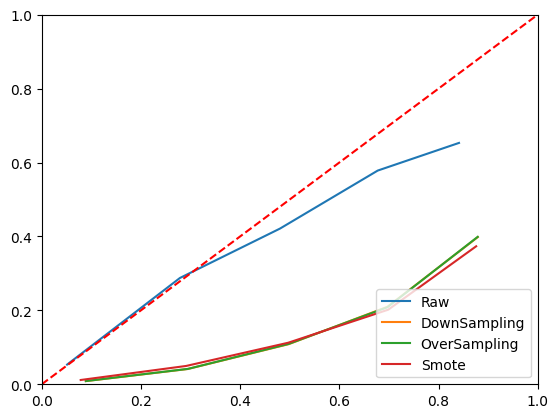

In [21]:
y_lr_raw, x_lr_raw = calibration_curve(y_test, lr_raw_prob, n_bins=5)
y_lr_rus, x_lr_rus = calibration_curve(y_test, lr_rus_prob, n_bins=5)
y_lr_ros, x_lr_ros = calibration_curve(y_test, lr_ros_prob, n_bins=5)
y_lr_smote, x_lr_smote = calibration_curve(y_test, lr_smote_prob, n_bins=5)
f1 = plt.figure()
plt.plot(x_lr_raw, y_lr_raw, label = "Raw")
plt.plot(x_lr_rus, y_lr_rus, label = "DownSampling")
plt.plot(x_lr_ros, y_lr_ros, label = "OverSampling")
plt.plot(x_lr_smote, y_lr_smote, label = "Smote")
plt.axline( (0,0),slope=1,linestyle='--',color='red')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='lower right')

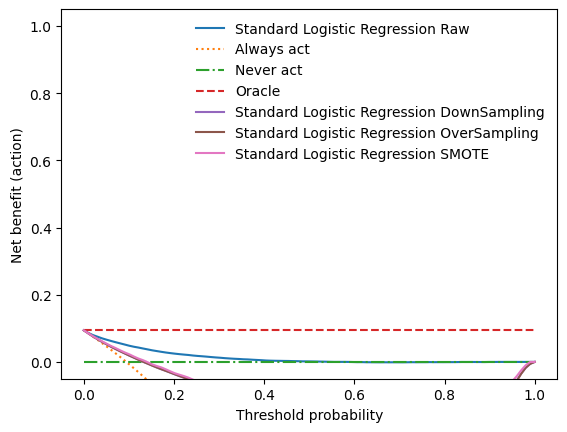

In [22]:
NetBenefitDisplay.from_predictions(y_test, lr_raw_prob, name='Standard Logistic Regression Raw')
NetBenefitDisplay.from_predictions(y_test, lr_rus_prob, name='Standard Logistic Regression DownSampling', show_references=False, ax=plt.gca())
NetBenefitDisplay.from_predictions(y_test, lr_ros_prob, name='Standard Logistic Regression OverSampling', show_references=False, ax=plt.gca())
NetBenefitDisplay.from_predictions(y_test, lr_smote_prob, name='Standard Logistic Regression SMOTE', show_references=False, ax=plt.gca())

In [23]:
lrL2_raw_prob = lr_L2_simulation(1, X_train, y_train, X_test, y_test)

Test accuracy: 0.551
Sensitivity: 0.123
Specificity: 0.989
Precision: 0.534
Calibrated Precision: 0.917
Recall: 0.123
F1 Score: 0.201
AUROC: 0.844
AUPRC: 0.360
Calibrated AUPRC: 0.821
0.5514730898367103
0.12345679012345678
0.9888156320038297
0.5344202898550725
0.9169320276773529
0.12345679012345678
0.20057793642699304
0.8443145469147053
0.36043934037353226
0.821251134946285


In [24]:
lrL2_rus_prob = lr_L2_simulation(1, X_rus, y_rus, X_test, y_test)

Test accuracy: 0.703
Sensitivity: 0.793
Specificity: 0.744
Precision: 0.244
Calibrated Precision: 0.756
Recall: 0.793
F1 Score: 0.373
AUROC: 0.844
AUPRC: 0.360
Calibrated AUPRC: 0.821
0.7031822925634488
0.7934714375392341
0.7439998259242335
0.24374879475477276
0.7560675570044096
0.7934714375392341
0.37293469708890636
0.8443618130930848
0.35981553367387475
0.8210190881511408


In [25]:
lrL2_ros_prob = lr_L2_simulation(1, X_ros, y_ros, X_test, y_test)

Test accuracy: 0.703
Sensitivity: 0.792
Specificity: 0.745
Precision: 0.244
Calibrated Precision: 0.756
Recall: 0.792
F1 Score: 0.373
AUROC: 0.844
AUPRC: 0.360
Calibrated AUPRC: 0.821
0.7028553941206666
0.7917974471646788
0.7447178884609527
0.24387728796081465
0.7561960699002815
0.7917974471646788
0.37289972899728996
0.8442914032883975
0.35988007534619204
0.8210140468641336


In [26]:
lrL2_smote_prob = lr_L2_simulation(1, X_smote, y_smote, X_test, y_test)

Test accuracy: 0.691
Sensitivity: 0.767
Specificity: 0.743
Precision: 0.237
Calibrated Precision: 0.749
Recall: 0.767
F1 Score: 0.362
AUROC: 0.831
AUPRC: 0.329
Calibrated AUPRC: 0.804
0.6912114374077198
0.7673153379368068
0.7431294470918467
0.23700879007238884
0.7491953802485666
0.7673153379368068
0.36215495531084885
0.8308755990564667
0.3287801498726774
0.804452047005159


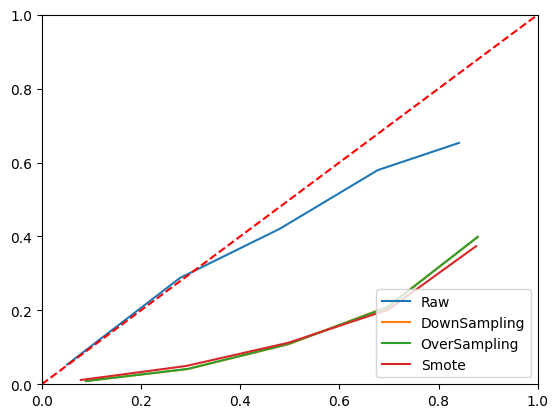

In [27]:
y_lrL2_raw, x_lrL2_raw = calibration_curve(y_test, lrL2_raw_prob, n_bins=5)
y_lrL2_rus, x_lrL2_rus = calibration_curve(y_test, lrL2_rus_prob, n_bins=5)
y_lrL2_ros, x_lrL2_ros = calibration_curve(y_test, lrL2_ros_prob, n_bins=5)
y_lrL2_smote, x_lrL2_smote = calibration_curve(y_test, lrL2_smote_prob, n_bins=5)
f1 = plt.figure()
plt.plot(x_lrL2_raw, y_lrL2_raw, label = "Raw")
plt.plot(x_lrL2_rus, y_lrL2_rus, label = "DownSampling")
plt.plot(x_lrL2_ros, y_lrL2_ros, label = "OverSampling")
plt.plot(x_lrL2_smote, y_lrL2_smote, label = "Smote")
plt.axline( (0,0),slope=1,linestyle='--',color='red')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='lower right')

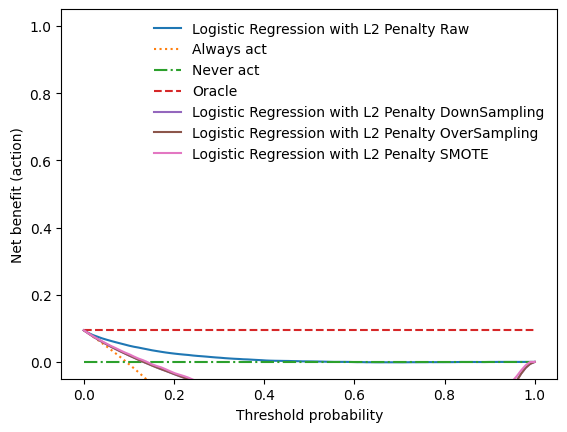

In [28]:
NetBenefitDisplay.from_predictions(y_test, lrL2_raw_prob, name='Logistic Regression with L2 Penalty Raw')
NetBenefitDisplay.from_predictions(y_test, lrL2_rus_prob, name='Logistic Regression with L2 Penalty DownSampling', show_references=False, ax=plt.gca())
NetBenefitDisplay.from_predictions(y_test, lrL2_ros_prob, name='Logistic Regression with L2 Penalty OverSampling', show_references=False, ax=plt.gca())
NetBenefitDisplay.from_predictions(y_test, lrL2_smote_prob, name='Logistic Regression with L2 Penalty SMOTE', show_references=False, ax=plt.gca())

In [29]:
rf_raw_prob = rf_simulation(1, X_train, y_train, X_test, y_test)

Best hyperparameters {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Test accuracy: 0.519
Sensitivity: 0.043
Specificity: 0.997
Precision: 0.608
Calibrated Precision: 0.937
Recall: 0.043
F1 Score: 0.081
AUROC: 0.844
AUPRC: 0.361
Calibrated AUPRC: 0.821
0.5188406909347459
0.04310525214480017
0.997105990382314
0.6076696165191741
0.9370857377531601
0.04310525214480017
0.08050019538882376
0.8442652591407955
0.3608342909777327
0.8212352328730284


In [30]:
rf_rus_prob = rf_simulation(1, X_rus, y_rus, X_test, y_test)

Best hyperparameters {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Test accuracy: 0.698
Sensitivity: 0.819
Specificity: 0.715
Precision: 0.230
Calibrated Precision: 0.742
Recall: 0.819
F1 Score: 0.360
AUROC: 0.843
AUPRC: 0.358
Calibrated AUPRC: 0.820
0.6983457739284915
0.8189997907512032
0.7154949191635659
0.2303843663547001
0.74218049402255
0.8189997907512032
0.35961043733921355
0.8433337133841867
0.35756334784744315
0.8195104866996625


In [31]:
rf_ros_prob = rf_simulation(1, X_ros, y_ros, X_test, y_test)

Best hyperparameters {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Test accuracy: 0.700
Sensitivity: 0.801
Specificity: 0.733
Precision: 0.238
Calibrated Precision: 0.750
Recall: 0.801
F1 Score: 0.367
AUROC: 0.844
AUPRC: 0.360
Calibrated AUPRC: 0.821
0.7001907262320526
0.8012136430215526
0.7327284200448245
0.23764895729890764
0.7498593577077511
0.8012136430215526
0.36656933607773684
0.8440128465475175
0.3595485261404641
0.8205535077295872


In [32]:
rf_smote_prob = rf_simulation(1, X_smote, y_smote, X_test, y_test)

Best hyperparameters {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Test accuracy: 0.687
Sensitivity: 0.671
Specificity: 0.810
Precision: 0.268
Calibrated Precision: 0.779
Recall: 0.671
F1 Score: 0.383
AUROC: 0.834
AUPRC: 0.327
Calibrated AUPRC: 0.805
0.6872266827403385
0.6708516426030551
0.8097787061818656
0.2683294275192501
0.7790880588945969
0.6708516426030551
0.3833323369402762
0.8335862057940631
0.32716089980875224
0.804626088409324


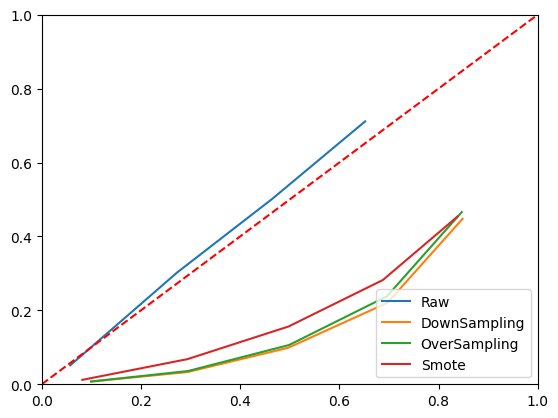

In [33]:
y_rf_raw, x_rf_raw = calibration_curve(y_test, rf_raw_prob, n_bins=5)
y_rf_rus, x_rf_rus = calibration_curve(y_test, rf_rus_prob, n_bins=5)
y_rf_ros, x_rf_ros = calibration_curve(y_test, rf_ros_prob, n_bins=5)
y_rf_smote, x_rf_smote = calibration_curve(y_test, rf_smote_prob, n_bins=5)
f1 = plt.figure()
plt.plot(x_rf_raw, y_rf_raw, label = "Raw")
plt.plot(x_rf_rus, y_rf_rus, label = "DownSampling")
plt.plot(x_rf_ros, y_rf_ros, label = "OverSampling")
plt.plot(x_rf_smote, y_rf_smote, label = "Smote")
plt.axline( (0,0),slope=1,linestyle='--',color='red')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='lower right')

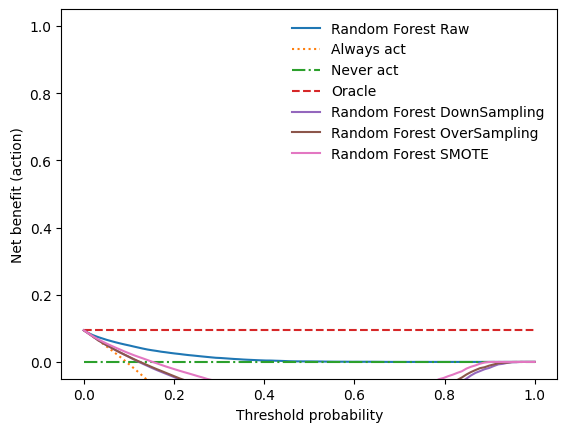

In [34]:
NetBenefitDisplay.from_predictions(y_test, rf_raw_prob, name='Random Forest Raw')
NetBenefitDisplay.from_predictions(y_test, rf_rus_prob, name='Random Forest DownSampling', show_references=False, ax=plt.gca())
NetBenefitDisplay.from_predictions(y_test, rf_ros_prob, name='Random Forest OverSampling', show_references=False, ax=plt.gca())
NetBenefitDisplay.from_predictions(y_test, rf_smote_prob, name='Random Forest SMOTE', show_references=False, ax=plt.gca())

Random seed set as 0
current loss: 0.23719220903684507 with an calibrated auprc of 0.8296125954478242
current loss: 0.235573632912066 with an calibrated auprc of 0.8321857684823086
current loss: 0.23653122960771406 with an calibrated auprc of 0.8331116810416369
current loss: 0.23653122960771406 with an calibrated auprc of 0.8331116810416369
current loss: 0.23534325505577544 with an calibrated auprc of 0.8347193109354314
current loss: 0.23534325505577544 with an calibrated auprc of 0.8347193109354314
current loss: 0.23534325505577544 with an calibrated auprc of 0.8347193109354314
current loss: 0.23534325505577544 with an calibrated auprc of 0.8347193109354314
current loss: 0.23534325505577544 with an calibrated auprc of 0.8347193109354314
current loss: 0.23534325505577544 with an calibrated auprc of 0.8347193109354314
current loss: 0.23534325505577544 with an calibrated auprc of 0.8347193109354314
current loss: 0.23534325505577544 with an calibrated auprc of 0.8347193109354314
current l

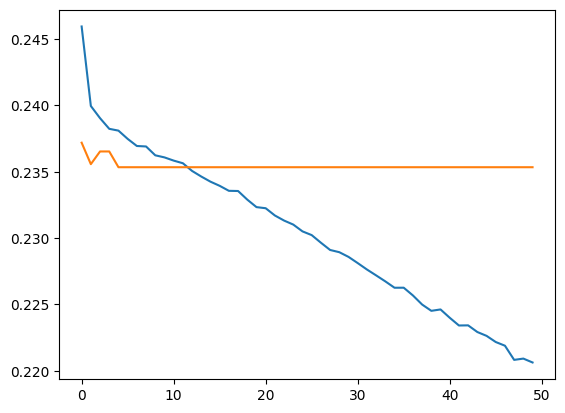

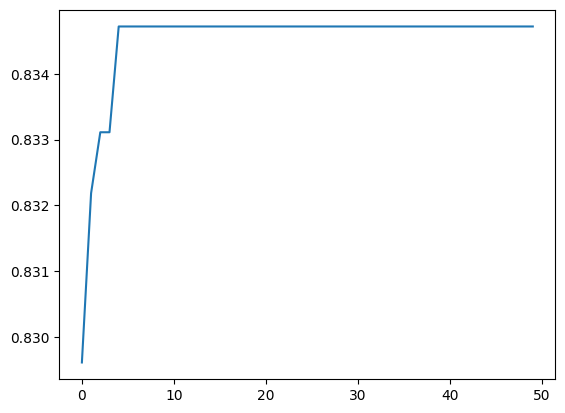

In [35]:
NN_raw_prob = NN_simulation(1, X_train, y_train, X_val, y_val, X_test, y_test, epochs = 50)

Random seed set as 0
current loss: 0.4853093316719967 with an calibrated auprc of 0.8266844607346282
current loss: 0.5256454277338471 with an calibrated auprc of 0.8281213629258195
current loss: 0.49526650463260197 with an calibrated auprc of 0.8285941161705443
current loss: 0.4945910033190025 with an calibrated auprc of 0.82955831327741
current loss: 0.4979718267542761 with an calibrated auprc of 0.8301433896869836
current loss: 0.4979718267542761 with an calibrated auprc of 0.8301433896869836
current loss: 0.4979718267542761 with an calibrated auprc of 0.8301433896869836
current loss: 0.4979718267542761 with an calibrated auprc of 0.8301433896869836
current loss: 0.4979718267542761 with an calibrated auprc of 0.8301433896869836
current loss: 0.4979718267542761 with an calibrated auprc of 0.8301433896869836
current loss: 0.4979718267542761 with an calibrated auprc of 0.8301433896869836
current loss: 0.4979718267542761 with an calibrated auprc of 0.8301433896869836
current loss: 0.4979

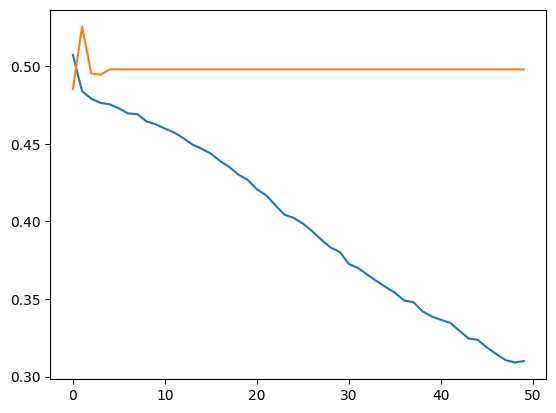

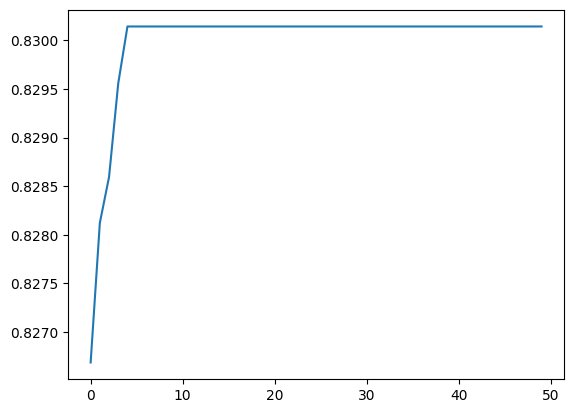

In [36]:
NN_rus_prob = NN_simulation(1, X_rus, y_rus, X_val, y_val, X_test, y_test, epochs = 50)

Random seed set as 0
current loss: 0.4849809095169763 with an calibrated auprc of 0.8318185267451221
current loss: 0.4849809095169763 with an calibrated auprc of 0.8318185267451221
current loss: 0.4849809095169763 with an calibrated auprc of 0.8318185267451221
current loss: 0.4849809095169763 with an calibrated auprc of 0.8318185267451221
current loss: 0.4849809095169763 with an calibrated auprc of 0.8318185267451221
current loss: 0.4849809095169763 with an calibrated auprc of 0.8318185267451221
current loss: 0.4849809095169763 with an calibrated auprc of 0.8318185267451221
current loss: 0.4849809095169763 with an calibrated auprc of 0.8318185267451221
current loss: 0.4849809095169763 with an calibrated auprc of 0.8318185267451221
current loss: 0.4849809095169763 with an calibrated auprc of 0.8318185267451221
current loss: 0.4849809095169763 with an calibrated auprc of 0.8318185267451221
current loss: 0.4849809095169763 with an calibrated auprc of 0.8318185267451221
current loss: 0.484

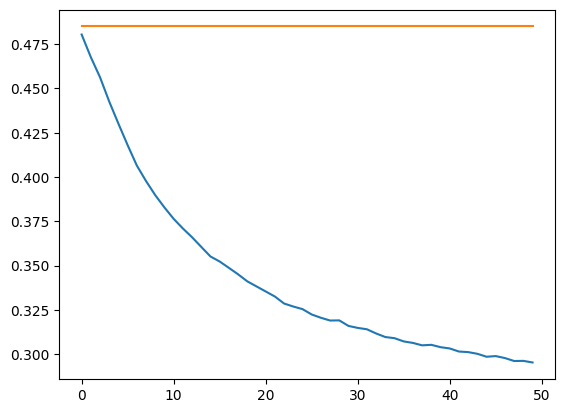

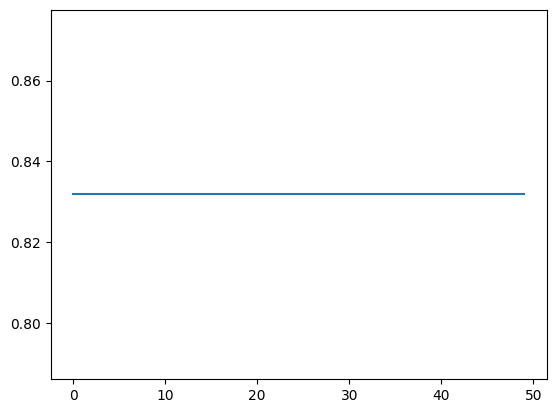

In [37]:
NN_ros_prob = NN_simulation(1, X_ros, y_ros, X_val, y_val, X_test, y_test, epochs = 50)

Random seed set as 0
current loss: 0.47999567486954936 with an calibrated auprc of 0.8057301401077732
current loss: 0.47999567486954936 with an calibrated auprc of 0.8057301401077732
current loss: 0.47999567486954936 with an calibrated auprc of 0.8057301401077732
current loss: 0.47999567486954936 with an calibrated auprc of 0.8057301401077732
current loss: 0.47999567486954936 with an calibrated auprc of 0.8057301401077732
current loss: 0.47999567486954936 with an calibrated auprc of 0.8057301401077732
current loss: 0.47999567486954936 with an calibrated auprc of 0.8057301401077732
current loss: 0.47999567486954936 with an calibrated auprc of 0.8057301401077732
current loss: 0.47999567486954936 with an calibrated auprc of 0.8057301401077732
current loss: 0.47999567486954936 with an calibrated auprc of 0.8057301401077732
current loss: 0.47999567486954936 with an calibrated auprc of 0.8057301401077732
current loss: 0.47999567486954936 with an calibrated auprc of 0.8057301401077732
current

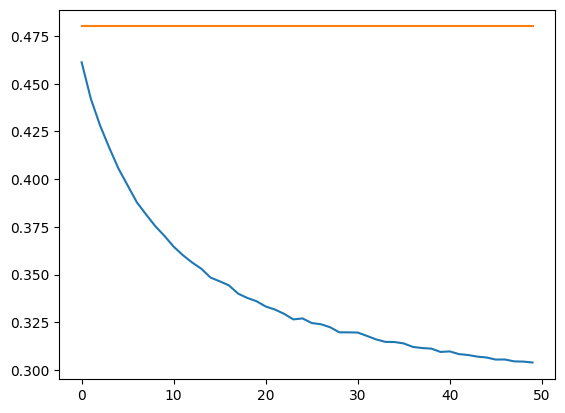

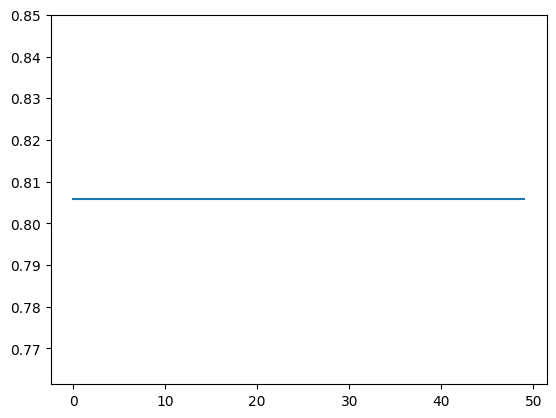

In [38]:
NN_smote_prob = NN_simulation(1, X_smote, y_smote, X_val, y_val, X_test, y_test, 50)

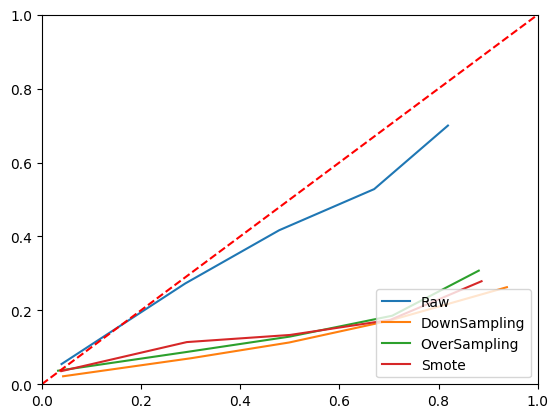

In [39]:
y_NN_raw, x_NN_raw = calibration_curve(y_test, NN_raw_prob, n_bins=5)
y_NN_rus, x_NN_rus = calibration_curve(y_test, NN_rus_prob, n_bins=5)
y_NN_ros, x_NN_ros = calibration_curve(y_test, NN_ros_prob, n_bins=5)
y_NN_smote, x_NN_smote = calibration_curve(y_test, NN_smote_prob, n_bins=5)
f1 = plt.figure()
plt.plot(x_NN_raw, y_NN_raw, label = "Raw")
plt.plot(x_NN_rus, y_NN_rus, label = "DownSampling")
plt.plot(x_NN_ros, y_NN_ros, label = "OverSampling")
plt.plot(x_NN_smote, y_NN_smote, label = "Smote")
plt.axline( (0,0),slope=1,linestyle='--',color='red')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='lower right')

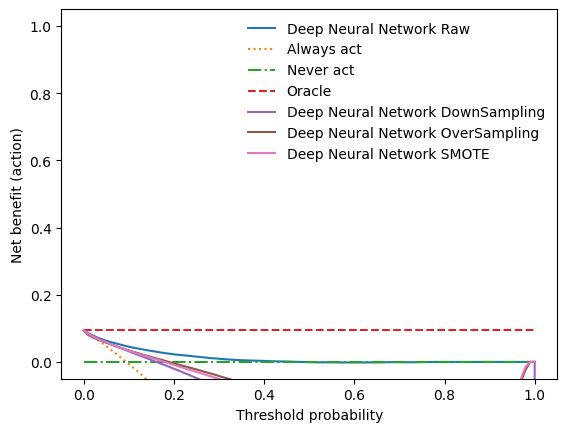

In [40]:
NetBenefitDisplay.from_predictions(y_test, NN_raw_prob, name='Deep Neural Network Raw')
NetBenefitDisplay.from_predictions(y_test, NN_rus_prob, name='Deep Neural Network DownSampling', show_references=False, ax=plt.gca())
NetBenefitDisplay.from_predictions(y_test, NN_ros_prob, name='Deep Neural Network OverSampling', show_references=False, ax=plt.gca())
NetBenefitDisplay.from_predictions(y_test, NN_smote_prob, name='Deep Neural Network SMOTE', show_references=False, ax=plt.gca())